In [145]:
import numpy as np
import re
import gensim
from random import shuffle

from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec,LabeledSentence
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [11]:
def remove_puncuation(line):
    rule = re.compile(r"[^a-zA-Z0-9\u4e00-\u9fa5]")
    line = rule.sub("",line)
    return line

In [57]:
with open("bd_small.txt",'r') as bdr:
    bdr_vec = bdr.readlines()
    temp=[]
    for i in bdr_vec:
        if len(i) == 1:
            pass
        else:
            temp.append(remove_puncuation(i))
    bdr_vec = temp
#     bdr_vec=[remove_puncuation(i) for i in bdr_vec]

In [288]:
len(bdr_vec)

13458

In [287]:
with open("bd_small.txt",'r') as bdr:
    bdr_vec = bdr.readlines()
    bdr_vec=[remove_puncuation(i) for i in bdr_vec]
with open("iot_small.txt",'r') as iot:
    iot_vec = iot.readlines()
    iot_vec=[remove_puncuation(i) for i in iot_vec]

In [5]:
y=np.concatenate((np.ones(len(bdr_vec)),np.zeros(len(iot_vec))))

dataset = np.concatenate((bdr_vec, iot_vec))
x_train, x_test, y_train, y_test = train_test_split(dataset, y, test_size=0.2)

In [277]:
len(bdr_vec)

817

In [289]:
##读取并预处理数据
def get_dataset():
    #读取数据
    with open("bd_small.txt",'r') as bdr:
        bdr_vec = bdr.readlines()
        temp=[]
        for i in bdr_vec:
            if len(i) < 30:
                pass
            else:
                temp.append(remove_puncuation(i))
        bdr_vec = temp
        bdr_vec=[remove_puncuation(i) for i in bdr_vec]
    with open("iot_small.txt",'r') as iot:
        iot_vec = iot.readlines()
        temp=[]
        for i in iot_vec:
            if len(i) < 30:
                pass
            else:
                temp.append(remove_puncuation(i))
        iot_vec = temp
        iot_vec=[remove_puncuation(i) for i in iot_vec]
    

    #使用1表示正面情感，0为负面
    y = np.concatenate((np.ones(len(bdr_vec)), np.zeros(len(iot_vec))))
    #将数据分割为训练与测试集
    x_train, x_test, y_train, y_test = train_test_split(np.concatenate((bdr_vec, iot_vec)), y, test_size=0.2)

    #对英文做简单的数据清洗预处理，中文根据需要进行修改
    def cleanText(corpus):
        punctuation = """.,?!:;(){}[]"""
        corpus = [z.lower().replace('\n','') for z in corpus]
        corpus = [z.replace('<br />', ' ') for z in corpus]

        #treat punctuation as individual words
        for c in punctuation:
            corpus = [z.replace(c, ' %s '%c) for z in corpus]
        corpus = [z.split() for z in corpus]
        return corpus

    x_train = cleanText(x_train)
    x_test = cleanText(x_test)
#     unsup_reviews = cleanText(unsup_reviews)

    #Gensim的Doc2Vec应用于训练要求每一篇文章/句子有一个唯一标识的label.
    #我们使用Gensim自带的LabeledSentence方法. 标识的格式为"TRAIN_i"和"TEST_i"，其中i为序号
    def labelizeReviews(reviews, label_type):
        labelized = []
        for i,v in enumerate(reviews):
            label = '%s_%s'%(label_type,i)
            labelized.append(LabeledSentence(v, [label]))
        return labelized

    x_train = labelizeReviews(x_train, 'TRAIN')
    x_test = labelizeReviews(x_test, 'TEST')

    return x_train,x_test,y_train, y_test

In [290]:
##读取向量
def getVecs(model, corpus, size):
    vecs = [np.array(model.docvecs[z.tags[0]]).reshape((1, size)) for z in corpus]
    return np.concatenate(vecs)


In [291]:
##对数据进行训练
def train(x_train,x_test,size = 400,epoch_num=10):
    #实例DM和DBOW模型
    model_dm = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, workers=2)
    model_dbow = gensim.models.Doc2Vec(min_count=1, window=10, size=size, sample=1e-3, negative=5, dm=0, workers=2)

    #使用所有的数据建立词典
    model_dm.build_vocab(x_train+x_test)
    model_dbow.build_vocab(x_train+x_test)
    
    
#     model_dm.build_vocab(np.concatenate((x_train, x_test)))
#     model_dbow.build_vocab(np.concatenate((x_train, x_test)))

    #进行多次重复训练，每一次都需要对训练数据重新打乱，以提高精度
#     all_train_reviews = np.concatenate((x_train))
    all_train_reviews = x_train
    for epoch in range(epoch_num):
#         perm = np.random.permutation(all_train_reviews.shape[0])
        shuffle(all_train_reviews)
        tralen=len(all_train_reviews)
        model_dm.train(all_train_reviews,total_examples=tralen,epochs=model_dm.iter)
        model_dbow.train(all_train_reviews,total_examples=tralen,epochs=model_dbow.iter)

#         model_dm.train(all_train_reviews[perm])
#         model_dbow.train(all_train_reviews[perm])

    #训练测试数据集
#     x_test = np.array(x_test)
    x_test=x_test
    for epoch in range(epoch_num):
        shuffle(x_test)
        model_dm.train(x_test,total_examples=len(x_test),epochs=model_dm.iter)
        model_dbow.train(x_test,total_examples=len(x_test),epochs=model_dbow.iter)
#         perm = np.random.permutation(x_test.shape[0])
#         model_dm.train(x_test[perm])
#         model_dbow.train(x_test[perm])

    return model_dm,model_dbow

In [292]:
##将训练完成的数据转换为vectors
def get_vectors(model_dm,model_dbow):

    #获取训练数据集的文档向量
    train_vecs_dm = getVecs(model_dm, x_train, size)
    train_vecs_dbow = getVecs(model_dbow, x_train, size)
    train_vecs = np.hstack((train_vecs_dm, train_vecs_dbow))
    #获取测试数据集的文档向量
    test_vecs_dm = getVecs(model_dm, x_test, size)
    test_vecs_dbow = getVecs(model_dbow, x_test, size)
    test_vecs = np.hstack((test_vecs_dm, test_vecs_dbow))

    return train_vecs,test_vecs

In [293]:
##使用分类器对文本向量进行分类训练
def Classifier(train_vecs,y_train,test_vecs, y_test):
    #使用sklearn的SGD分类器
    from sklearn.linear_model import SGDClassifier

    lr = SGDClassifier(loss='log', penalty='l1')
    lr.fit(train_vecs, y_train)

    print('Test Accuracy: %.2f'%lr.score(test_vecs, y_test))

    return lr

In [294]:
##绘出ROC曲线，并计算AUC
def ROC_curve(lr,y_test):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    pred_probas = lr.predict_proba(test_vecs)[:,1]

    fpr,tpr,_ = roc_curve(y_test, pred_probas)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.2f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.show()

Test Accuracy: 0.49


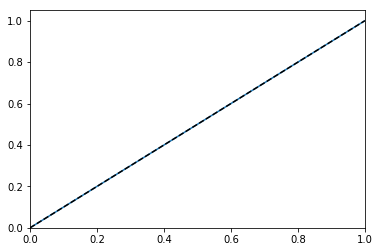

In [295]:
##运行模块
if __name__ == "__main__":
    #设置向量维度和训练次数
    size,epoch_num = 400,10
    #获取训练与测试数据及其类别标注
    x_train,x_test,y_train, y_test = get_dataset()
    #对数据进行训练，获得模型
    model_dm,model_dbow = train(x_train,x_test,size,epoch_num)
    #从模型中抽取文档相应的向量
    train_vecs,test_vecs = get_vectors(model_dm,model_dbow)
    #使用文章所转换的向量进行情感正负分类训练
    lr=Classifier(train_vecs,y_train,test_vecs, y_test)
    #画出ROC曲线
    ROC_curve(lr,y_test)

In [296]:
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
Y = np.array([1, 1, 1, 2, 2, 2])


from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(train_vecs, y_train)
GaussianNB(priors=None)
# print(clf.predict([[-0.8, -1]]))
print('Test Accuracy: %.2f'%clf.score(test_vecs, y_test))



clf_pf = GaussianNB()
clf_pf.partial_fit(train_vecs, y_train, np.unique(y_train))
GaussianNB(priors=None)
# print(clf_pf.predict([[-0.8, -1]]))
print('Test Accuracy: %.2f'%clf.score(test_vecs, y_test))

Test Accuracy: 0.50
Test Accuracy: 0.50


In [ ]:
def Classifier(train_vecs,y_train,test_vecs, y_test):
    #使用sklearn的SGD分类器
    from sklearn.linear_model import SGDClassifier

    lr = SGDClassifier(loss='log', penalty='l1')
    lr.fit(train_vecs, y_train)

    print('Test Accuracy: %.2f'%lr.score(test_vecs, y_test))

    return lr